In [234]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
import pandas as pd

In [235]:
df = pd.read_csv('./csv/clinical data.csv', sep=';')
df.head()

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,M-Stage,Histopathological grading,Smoking History
0,A0001,M,58.0,65.0,2b,3,1b,G3,1
1,A0002,F,53.0,55.0,2b,1,0,NaN,0
2,A0003,M,60.0,62.0,1c,1,0,G3,0
3,A0004,F,48.0,56.0,1c,3,0,NaN,0
4,A0005,M,70.0,75.0,1b,0,0,G2,1


In [236]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
def dir_to_staging(img_dir, class_list, stage):
    arr = []
    data_dir = os.listdir(img_dir)
    data_dir.sort()
    for pict in data_dir:
        res = df[df["NewPatientID"].str.contains(pict[:5])]
        arr.append(class_list.index(
            str(res[stage+"-Stage"].values[0])[0])
            )
    res = to_categorical(arr, len(class_list))
    np_res = np.array(res)
    return np_res

In [237]:
from tensorflow.keras.preprocessing.image import load_img, random_rotation, random_shear, random_shift
import numpy as np
def img_loader(path, processed = False):
    arr = []
    img_list = os.listdir(path)
    img_list.sort()
    for pict in img_list:
        # print('/'.join([path, pict]))
        img = load_img(
            path='/'.join([path, pict]), 
            color_mode='rgb', 
            target_size = (224, 224))
        img = np.array(img)
        if(processed):
            img = random_rotation(img, 20)
            img = random_shear(img, 0.25)
            img = random_shift(img, 0.25, 0.25)
        arr.append(img)
    res = np.array(arr)
    return res

In [238]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def conf_matrix(x_test, y_test, model):
    y_true = []
    y_pred = []
    res = model.predict(x_test, verbose=0)
    for i in range(len(x_test)):
        y_true.append(np.argmax(y_test[i]))
        y_pred.append(np.argmax(res[i]))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return y_true, y_pred

In [395]:
# label staging
T = ["1", "2", "3", "4"]
N = ["0","1", "2", "3"]
M = ["0","1"]


BATCH_SIZE = 32

In [241]:
src_path_train_tnm = "./Data_pet_CT_TNM/train/img"
src_path_valid_tnm = "./Data_pet_CT_TNM/valid/img"
src_path_test_tnm = "./Data_pet_CT_TNM/test/img"


X_train = img_loader(src_path_train_tnm, True)
X_valid = img_loader(src_path_valid_tnm)
X_test = img_loader(src_path_test_tnm)

In [396]:
STEPS_PER_EPOCH_TRAINING = int((len(X_train) / BATCH_SIZE)+1)
STEPS_PER_EPOCH_VALIDATION = int((len(X_valid) / BATCH_SIZE)+1)

## T staging

In [242]:
T_train = dir_to_staging(src_path_train_tnm, T, "T")
T_valid = dir_to_staging(src_path_valid_tnm, T, "T")
T_test = dir_to_staging(src_path_test_tnm, T, "T")

In [328]:
model = Sequential()

# base model
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.layers[0].trainable = False

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(T), activation = 'softmax'))


In [329]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_28 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_28 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 128)               262272    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 4)                 516       
                                                     

In [180]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(
    learning_rate = 0.01)
model.compile(
    optimizer = sgd, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [330]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(
    learning_rate = 0.01)
model.compile(
    optimizer = adam, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [331]:
fit_history = model.fit(
        x=X_train, 
        y=T_train,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=(X_valid, T_valid),
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        batch_size = BATCH_SIZE
)

Epoch 1/50
26/26 [==============================] - 5s 127ms/step - loss: 4.9537 - accuracy: 0.5702 - val_loss: 1.7456 - val_accuracy: 0.6436
Epoch 2/50
26/26 [==============================] - 3s 104ms/step - loss: 2.3883 - accuracy: 0.7354 - val_loss: 0.8775 - val_accuracy: 0.7447
Epoch 3/50
26/26 [==============================] - 3s 104ms/step - loss: 1.0604 - accuracy: 0.8497 - val_loss: 1.6209 - val_accuracy: 0.6489
Epoch 4/50
26/26 [==============================] - 3s 104ms/step - loss: 0.7298 - accuracy: 0.8658 - val_loss: 0.8052 - val_accuracy: 0.8138
Epoch 5/50
26/26 [==============================] - 3s 104ms/step - loss: 0.3831 - accuracy: 0.9230 - val_loss: 0.7559 - val_accuracy: 0.7660
Epoch 6/50
26/26 [==============================] - 3s 104ms/step - loss: 0.3876 - accuracy: 0.9168 - val_loss: 0.6878 - val_accuracy: 0.8032
Epoch 7/50
26/26 [==============================] - 3s 104ms/step - loss: 0.5313 - accuracy: 0.9242 - val_loss: 0.5050 - val_accuracy: 0.8617
Epoch 

In [332]:
model.save('./models/TNM-final/model-t-a-3.h5')

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


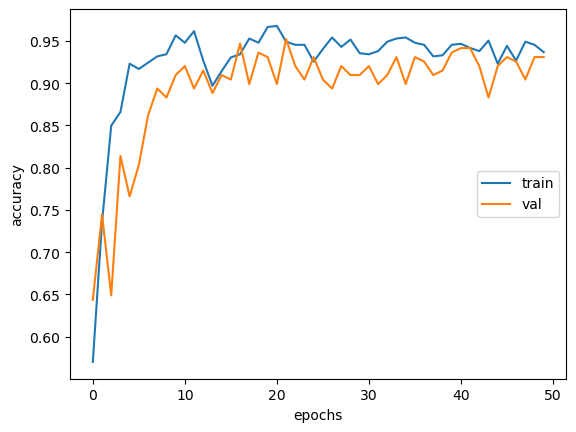

In [333]:
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

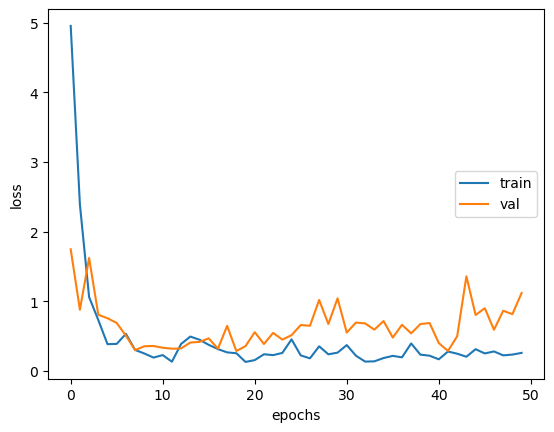

In [334]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [335]:
model.evaluate(x=X_test, y=T_test, batch_size=1)

91/91 [==============================] - 2s 14ms/step - loss: 0.5343 - accuracy: 0.9121


[0.5342984795570374, 0.9120879173278809]

9/9 [==============================] - 1s 29ms/step
T stage prediction


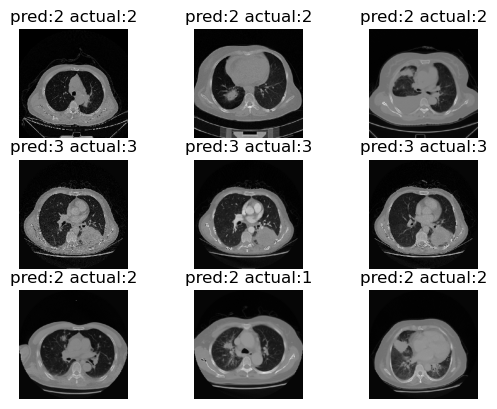

In [336]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("T stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+T[np.argmax(res[i])]+" actual:"+ T[np.argmax(T_test[i])])
    plt.axis('off')
plt.show()

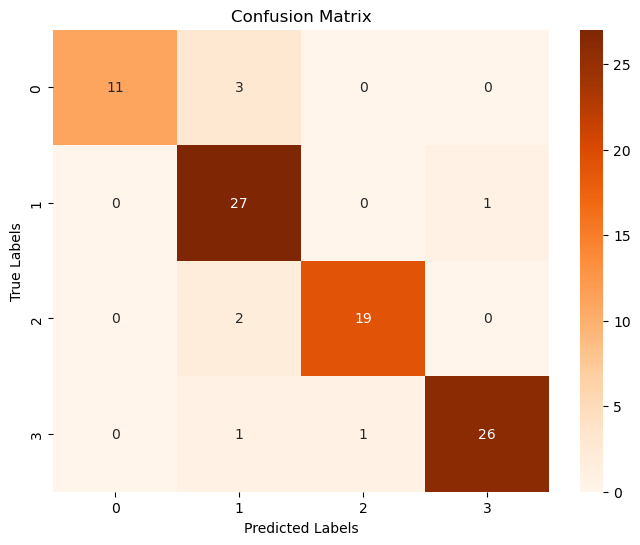

In [337]:
y_true, y_pred = conf_matrix(X_test, T_test, model)

In [338]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(y_true, y_pred , average="macro"))
print(recall_score(y_true, y_pred , average="macro"))
print(f1_score(y_true, y_pred , average="macro"))

0.9327861952861953
0.8958333333333333
0.9093824288466431


## N Staging

In [254]:
N_train = dir_to_staging(src_path_train_tnm, N, "N")
N_valid = dir_to_staging(src_path_valid_tnm, N, "N")
N_test = dir_to_staging(src_path_test_tnm, N, "N")

In [339]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.layers[0].trainable = False

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(N), activation = 'softmax'))

In [340]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_29 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_29 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_47 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 4)                 516       
                                                     

In [191]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(
    learning_rate = 0.01)
model.compile(
    optimizer = sgd, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [341]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(
    learning_rate = 0.01)
model.compile(
    optimizer = adam, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [342]:
fit_history = model.fit(
        x=X_train, 
        y=N_train,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=(X_valid, N_valid),
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        batch_size = BATCH_SIZE
)

Epoch 1/50
26/26 [==============================] - 6s 131ms/step - loss: 4.8369 - accuracy: 0.5789 - val_loss: 2.7858 - val_accuracy: 0.6064
Epoch 2/50
26/26 [==============================] - 3s 108ms/step - loss: 1.9566 - accuracy: 0.7602 - val_loss: 2.8976 - val_accuracy: 0.5798
Epoch 3/50
26/26 [==============================] - 3s 109ms/step - loss: 0.9682 - accuracy: 0.8584 - val_loss: 1.8081 - val_accuracy: 0.6223
Epoch 4/50
26/26 [==============================] - 3s 108ms/step - loss: 0.5228 - accuracy: 0.8870 - val_loss: 0.3960 - val_accuracy: 0.8670
Epoch 5/50
26/26 [==============================] - 3s 108ms/step - loss: 0.3983 - accuracy: 0.9280 - val_loss: 0.2243 - val_accuracy: 0.9043
Epoch 6/50
26/26 [==============================] - 3s 107ms/step - loss: 0.3322 - accuracy: 0.9304 - val_loss: 0.2696 - val_accuracy: 0.9149
Epoch 7/50
26/26 [==============================] - 3s 107ms/step - loss: 0.2275 - accuracy: 0.9466 - val_loss: 0.3391 - val_accuracy: 0.9096
Epoch 

In [343]:
model.save('./models/TNM-final/model-n-a-3.h5')

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


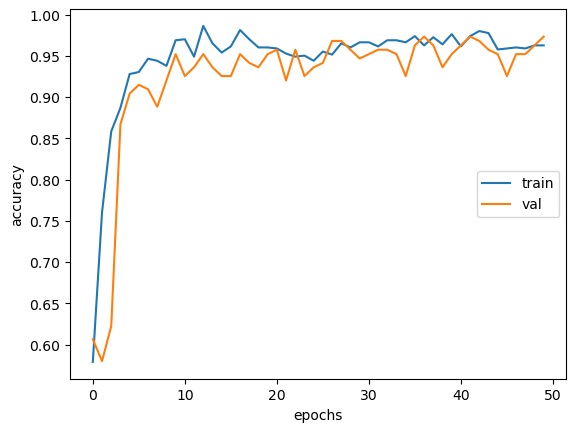

In [344]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

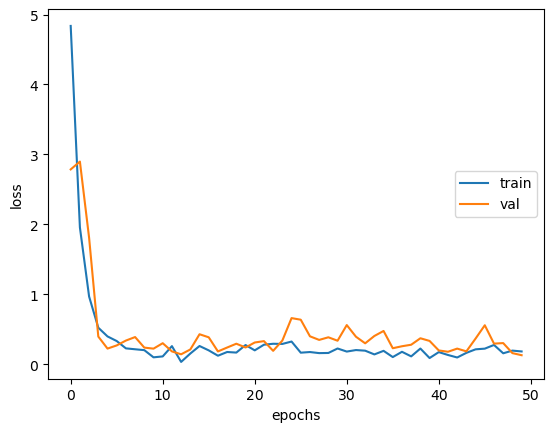

In [345]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [346]:
model.evaluate(x=X_test, y=N_test, batch_size=1)

91/91 [==============================] - 2s 16ms/step - loss: 0.1607 - accuracy: 0.9560


[0.16066312789916992, 0.9560439586639404]

9/9 [==============================] - 1s 11ms/step
N stage prediction


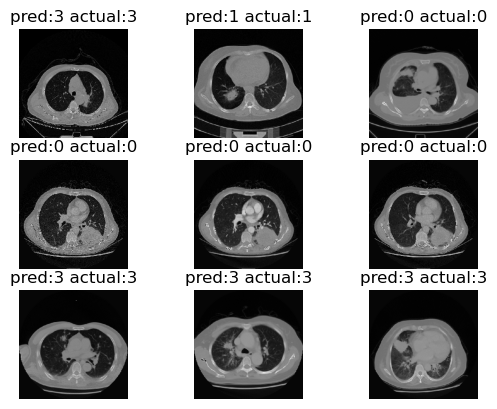

In [347]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("N stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+N[np.argmax(res[i])]+" actual:"+ N[np.argmax(N_test[i])])
    plt.axis('off')
plt.show()

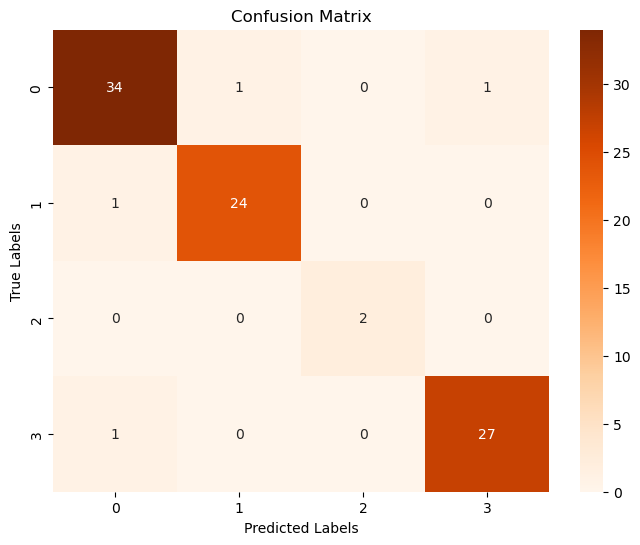

In [348]:
y_true, y_pred = conf_matrix(X_test, N_test, model)

In [349]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(y_true, y_pred , average="macro"))
print(recall_score(y_true, y_pred , average="macro"))
print(f1_score(y_true, y_pred , average="macro"))

0.9671825396825398
0.9671825396825398
0.9671825396825398


## M staging

In [267]:
M_train = dir_to_staging(src_path_train_tnm, M, "M")
M_valid = dir_to_staging(src_path_valid_tnm, M, "M")
M_test = dir_to_staging(src_path_test_tnm, M, "M")

In [383]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.layers[0].trainable = False

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(M), activation = 'softmax'))

In [384]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_32 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_32 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_53 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23600002 (90.03 MB)
Trainable params: 8194 (32.01 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [225]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(
    learning_rate = 0.01)
model.compile(
    optimizer = sgd, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [385]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(
    learning_rate = 0.01)
model.compile(
    optimizer = adam, 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [386]:
fit_history = model.fit(
        x=X_train, 
        y=M_train,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 50,
        validation_data=(X_valid, M_valid),
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        batch_size = BATCH_SIZE
)

Epoch 1/50
26/26 [==============================] - 5s 125ms/step - loss: 1.2301 - accuracy: 0.7168 - val_loss: 0.8754 - val_accuracy: 0.6862
Epoch 2/50
26/26 [==============================] - 3s 105ms/step - loss: 0.3440 - accuracy: 0.9068 - val_loss: 1.0694 - val_accuracy: 0.6755
Epoch 3/50
26/26 [==============================] - 3s 105ms/step - loss: 0.1947 - accuracy: 0.9366 - val_loss: 0.2580 - val_accuracy: 0.9043
Epoch 4/50
26/26 [==============================] - 3s 105ms/step - loss: 0.1506 - accuracy: 0.9565 - val_loss: 0.3878 - val_accuracy: 0.8830
Epoch 5/50
26/26 [==============================] - 3s 105ms/step - loss: 0.1028 - accuracy: 0.9602 - val_loss: 0.3473 - val_accuracy: 0.8777
Epoch 6/50
26/26 [==============================] - 3s 105ms/step - loss: 0.1347 - accuracy: 0.9553 - val_loss: 0.4919 - val_accuracy: 0.8617
Epoch 7/50
26/26 [==============================] - 3s 105ms/step - loss: 0.0794 - accuracy: 0.9665 - val_loss: 0.3355 - val_accuracy: 0.9255
Epoch 

In [387]:
model.save('./models/TNM-final/model-m-a-1.h5')

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


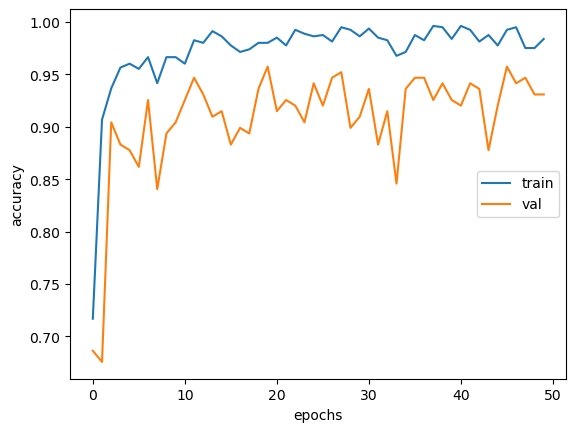

In [388]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

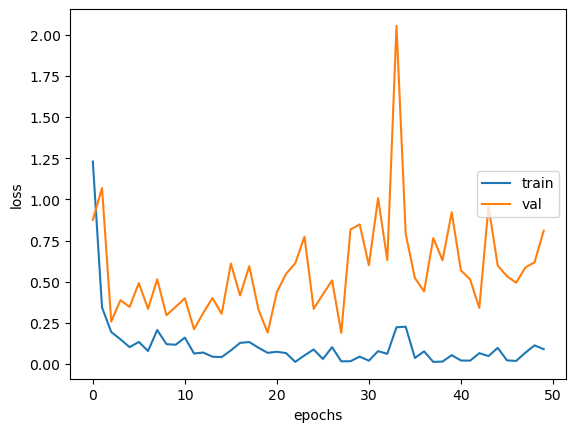

In [389]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [390]:
model.evaluate(x=X_test, y=M_test, batch_size=1)

91/91 [==============================] - 2s 15ms/step - loss: 1.5362 - accuracy: 0.8791


[1.5362273454666138, 0.8791208863258362]

9/9 [==============================] - 1s 29ms/step
M stage prediction


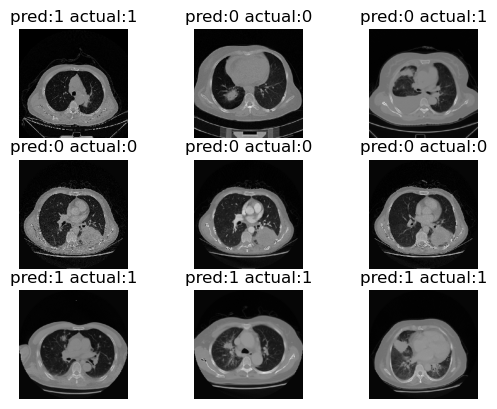

In [391]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("M stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+M[np.argmax(res[i])]+" actual:"+ M[np.argmax(M_test[i])])
    plt.axis('off')
plt.show()

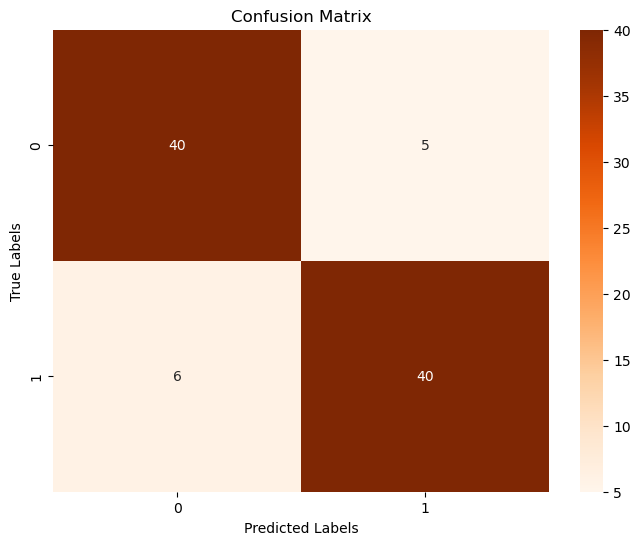

In [392]:
y_true, y_pred = conf_matrix(X_test, M_test, model)

In [393]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(y_true, y_pred , average="macro"))
print(recall_score(y_true, y_pred , average="macro"))
print(f1_score(y_true, y_pred , average="macro"))

0.8792270531400965
0.8792270531400965
0.8791208791208791
